# Tutorial 1. Polynomial logistic regression versus multi-layer perceptron

In this notebook, we compare on toy datasets the polynomial logistic regression with a multi-layer perceptron (MLP) for binary classification.

- Polynomial logistic regression is a basic example of a linear method (logistic regression) applied on hand-made features (involving feature engineering)
- Multi-layer perceptron won't benefit from the hand-made polynomial features

This example is therefore a toy comparison, on toy datasets, of a hand-craft approach, with hand-made polynomial features and a purely data-driven approach, based on a MLP.

## Simulation of three datasets for illustration

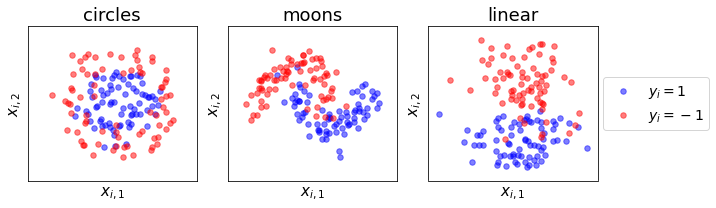

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_classification, make_circles
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def make_linear(n_samples):    
    X, y = make_classification(
        n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2, 
        random_state=1, n_clusters_per_class=1
     )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    return X, y

n_samples = 150

datasets = [
    (make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1), "circles"),
    (make_moons(n_samples=n_samples, noise=0.2, random_state=0), "moons"),
    (make_linear(n_samples=n_samples), "linear")
]

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(ax, X, y, xy_labels=True, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=r"$y_i=1$", **kwargs)
    plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=r"$y_i=-1$", **kwargs)
    ax.set_xticks(())
    ax.set_yticks(())
    if xy_labels:
        ax.set_xlabel(r"$x_{i,1}$", fontsize=15)
        ax.set_ylabel(r"$x_{i,2}$", fontsize=15)
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

n_datasets = len(datasets)
plt.figure(figsize=(10, 3))

for i, ((X, y), name) in enumerate(datasets):
    ax = plt.subplot(1, n_datasets, i + 1)
    plot_data(ax, X, y, alpha=0.5)
    plt.title(name, fontsize=18)

plt.legend(fontsize=14, loc="center right", bbox_to_anchor=(1.7, 0.5))
plt.tight_layout()

# plt.savefig("tutorial01b_toy_samples.pdf")

## Decision functions of the logistic regression on these datasets


In [2]:
# Instantiate a logistic regression
clf = LogisticRegression()

# Fit the model on data
clf.fit(X, y)

LogisticRegression()

In [3]:
# Learned weights
clf.coef_

array([[-0.36171595, -2.97407563]])

In [4]:
# Learned intercept
clf.intercept_

array([3.19444082])

In [5]:
# To predict the label
clf.predict(X[:5])

array([1, 0, 1, 0, 1])

In [6]:
# To get predictions of the probability
clf.predict_proba(X[:5])

array([[0.00296966, 0.99703034],
       [0.71044756, 0.28955244],
       [0.03038268, 0.96961732],
       [0.99435025, 0.00564975],
       [0.02405746, 0.97594254]])

In [7]:
# The decision function: it's x w + b (the linear transform before applying the sigmoid)
clf.decision_function(X[:5])

array([ 5.81633516, -0.89755869,  3.46302889, -5.17047897,  3.70295855])

## Display of the predicted probabilities

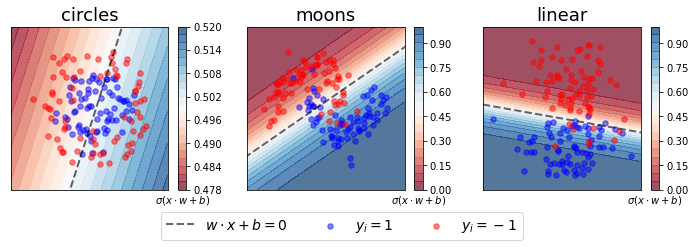

In [8]:
clf = LogisticRegression()

n_datasets = len(datasets)
plt.figure(figsize=(12, 3))
h = 0.02
levels = 20

def plot_hyperplane(clf, x_min=-10., x_max=10.):
    if isinstance(clf, Pipeline):
        w1, w2 = clf["logreg"].coef_[0]
        b = clf["logreg"].intercept_
    else:
        w1, w2 = clf.coef_[0]
        b = clf.intercept_

    x = np.linspace(-10, 10, 1000)
    y = -(b + w1 * x) / w2
    plt.plot(x, y, lw=2, ls="--", color="black", alpha=0.6, 
             label=r"$w \cdot x + b = 0$")

def plot_data(ax, X, y, xy_labels=True, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=r"$y_i=1$", **kwargs)
    plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=r"$y_i=-1$", **kwargs)
    ax.set_xticks(())
    ax.set_yticks(())
    if xy_labels:
        ax.set_xlabel(r"$x_{i,1}$", fontsize=15)
        ax.set_ylabel(r"$x_{i,2}$", fontsize=15)
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)


def plot_probas(clf, ax, X, y, h=0.02, levels=20, colorbar=True):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ct = ax.contourf(xx, yy, Z, cmap=cm, alpha=.7, levels=levels)
    if colorbar:
        cbar = plt.colorbar(ct)
        cbar.ax.set_xlabel(r"$\sigma(x \cdot w + b)$")
    
for i, ((X, y), name) in enumerate(datasets):
    ax = plt.subplot(1, n_datasets, i + 1)
    clf.fit(X, y)
    plot_probas(clf, ax, X, y, h=h, levels=levels)
    plot_hyperplane(clf, x_min=X[:, 0].min(), x_max=X[:, 0].max())
    plot_data(ax, X, y, xy_labels=False, alpha=0.5)
    plt.title(name, fontsize=18)

lgd = plt.legend(fontsize=14, loc="lower center", ncol=3, bbox_to_anchor=(-0.9, -0.35))

# plt.savefig("tutorial01b_logistic_probas.pdf", 
#             bbox_extra_artists=(lgd,), bbox_inches='tight')

## Decision function of a polynomial logistic regression

Let's use the `PolynomialFeatures` transformer before performing the logistic regression in a scikit-learn `Pipeline`

circles
[[-3.56596160e-06  3.05047536e-02  1.38409692e-01 -3.17444455e+00
   2.57929995e-01 -3.34511327e+00]]
moons
[[-2.46594732e-05  1.40129525e+00 -2.07575507e+00  5.40161184e-02
  -8.99409728e-01 -8.84329925e-01]]
linear
[[ 1.62693802e-04 -2.50619283e-01 -1.04070228e+00 -1.17238407e-02
  -4.68232400e-01 -1.38293660e+00]]


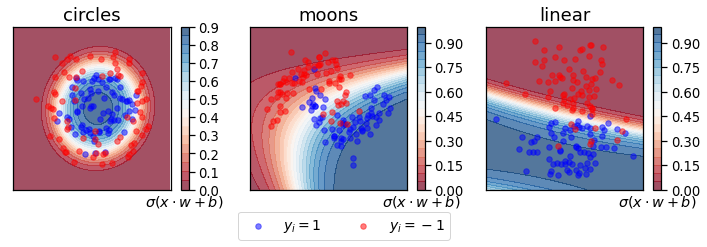

In [42]:
clf = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),
    ("logreg", LogisticRegression())
])

n_datasets = len(datasets)
plt.figure(figsize=(12, 3))
h = 0.02
levels = 20

for i, ((X, y), name) in enumerate(datasets):
    print(name)
    ax = plt.subplot(1, n_datasets, i + 1)
    clf.fit(X, y)
    print(clf["logreg"].coef_)
    plot_probas(clf, ax, X, y, h=h, levels=levels)
    plot_data(ax, X, y, xy_labels=False, alpha=0.5)
    plt.title(name, fontsize=18)

lgd = plt.legend(fontsize=14, loc="lower center", ncol=3, bbox_to_anchor=(-0.9, -0.35))

# plt.savefig("tutorial01b_poly_logistic_decision.pdf", 
#             bbox_extra_artists=(lgd,), bbox_inches='tight')

## Evaluation of the classifiers  using a classification report

Using the following classifiers: **simple logistic regression** and **polynomial logistic regression**, and let's scale the features before hand in the pipelines.

In [10]:
from sklearn.preprocessing import StandardScaler

clf_simple = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

clf_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2)),
    ("logreg", LogisticRegression())
])

We need to split the data into a **training** and a **testing** set

In [11]:
from sklearn.model_selection import train_test_split

# Let's use the "circles" dataset with more samples
n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1)

# And split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape

((750, 2), (250, 2))

In [12]:
from sklearn.metrics import (classification_report, roc_curve, 
                             precision_recall_curve, roc_auc_score, 
                             average_precision_score)

clf_simple.fit(X_train, y_train)
clf_poly.fit(X_train, y_train)

msg = "Classification report for clf_simple"
print(msg)
print("-" * len(msg))
report_simple = classification_report(y_test, clf_simple.predict(X_test))
print(report_simple)

msg = "Classification report for clf_poly"
print(msg)
print("-" * len(msg))
report_poly = classification_report(y_test, clf_poly.predict(X_test))
print(report_poly)

Classification report for clf_simple
------------------------------------
              precision    recall  f1-score   support

           0       0.42      0.61      0.50       118
           1       0.42      0.26      0.32       132

    accuracy                           0.42       250
   macro avg       0.42      0.43      0.41       250
weighted avg       0.42      0.42      0.41       250

Classification report for clf_poly
----------------------------------
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       118
           1       0.89      0.94      0.91       132

    accuracy                           0.90       250
   macro avg       0.91      0.90      0.90       250
weighted avg       0.91      0.90      0.90       250



**Note.** `macro avg` is the average of the metrics while `weighted avg` is the average weighted by the label proportions (important when data is unbalanced)

## Evaluation of the classifiers  using a ROC and PR curves

Let us first get the scores for the label 1 of the simple and the polynomial logistic regressions.

In [13]:
# Get the scores for class 1 of the simple and polynomial logistic regressions
y_score_simple = clf_simple.predict_proba(X_test)[:, 1]
y_score_poly = clf_poly.predict_proba(X_test)[:, 1]

In the next cell are **custom function** to plot nice-looking ROC curves with or without the thresholds

In [14]:
def plot_roc_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    thresholds[0] = 1
    roc_auc = roc_auc_score(y_test, y_score)

    if label is None:
        label='ROC curve (area = %0.2f)' % roc_auc

    if title is None:
        title = "ROC curve"

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(fpr, tpr, lw=1, label=label, alpha=0.7)
        plt.scatter(fpr, tpr, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(fpr, tpr, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_roc_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_roc_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)        

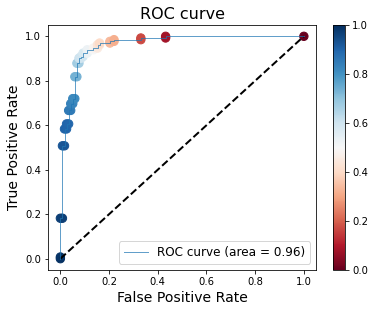

In [15]:
plt.figure(figsize=(6, 4.5))
plot_roc_curve(y_test, y_score_poly)

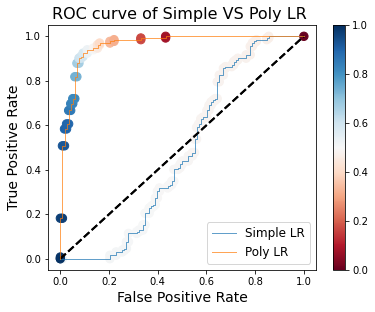

In [16]:
plt.figure(figsize=(6, 4.5))
plot_roc_curves(y_test, [y_score_simple, y_score_poly], 
                labels=["Simple LR", "Poly LR"],
                title="ROC curve of Simple VS Poly LR ")

# plt.tight_layout()
# plt.savefig("tutorial01b_roc_curves_with_thresholds.pdf")

Lets do the exact same thing with the precision recall curve

In [17]:
def plot_pr_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    precision = precision[:-1]
    recall = recall[:-1]
    avg_prec = average_precision_score(y_test, y_score)

    if label is None:
        label='PR curve (area = %0.2f)' % avg_prec

    if title is None:
        title = "PR curve"
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(recall, precision, lw=1, label=label, alpha=0.7)
        plt.scatter(recall, precision, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(recall, precision, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_pr_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_pr_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)        

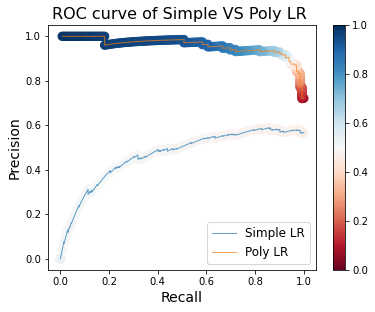

In [18]:
plt.figure(figsize=(6, 4.5))
plot_pr_curves(y_test, [y_score_simple, y_score_poly], 
               labels=["Simple LR", "Poly LR"],
               title="ROC curve of Simple VS Poly LR ")

# plt.tight_layout()
# plt.savefig("tutorial01b_pr_curves_with_thresholds.pdf")

## Comparisons over the three datasets using all the metrics

In [19]:
n_samples = 1000

datasets = [
    (make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1), "circles"),
    (make_moons(n_samples=n_samples, noise=0.2, random_state=0), "moons"),
    (make_linear(n_samples=n_samples), "linear")
]

clf_simple = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

clf_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2)),
    ("logreg", LogisticRegression())
])    

classifiers = [
    (clf_simple, "Simple LR"),
    (clf_poly, "Poly LR")
]

dataset_names = []
classifier_names = []
auc_prs = []
auc_rocs = []

for (X, y), dataset_name in datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    for clf, classifier_name in classifiers:
        # Train
        clf.fit(X_train, y_train)
        # Predict scores
        y_score = clf.predict_proba(X_test)[:, 1]
        # Compute AUC-ROC and AUC-PR (average-precision)
        auc_roc = roc_auc_score(y_test, y_score)
        auc_pr = average_precision_score(y_test, y_score)
        # Append computations in the lists
        dataset_names.append(dataset_name)
        classifier_names.append(classifier_name)
        auc_prs.append(auc_pr)
        auc_rocs.append(auc_roc)

In [20]:
results = pd.DataFrame({
    "dataset": dataset_names,
    "classifier": classifier_names,
    "AUC-ROC": auc_rocs,
    "AUC-PR": auc_prs
})
results

,dataset,classifier,AUC-ROC,AUC-PR
0,circles,Simple LR,0.479135,0.470386
1,circles,Poly LR,0.961929,0.958676
2,moons,Simple LR,0.921997,0.936578
3,moons,Poly LR,0.921804,0.936657
4,linear,Simple LR,0.930769,0.933180
5,linear,Poly LR,0.939038,0.929822


But we want to display the methods against the datasets, so let's **pivot** the dataframe

In [21]:
(
    results
    .pivot(index="classifier", columns="dataset")
    .style
    .background_gradient()
)

We see that on the **circles** dataset, **Poly LR** is much better than **Simple LR**, while on the **linear** and the **moons** datasets, Simple LR and Poly LR have similar performances.

## Illustration of overfitting with polynomial logistic regression

Let's illustrate overfitting by increasing the degree of the polynomial

In [22]:
def get_poly_logreg(degree):
    clf = Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("scale", StandardScaler()),        
        ("logreg", LogisticRegression(penalty="none", max_iter=5000))
    ])
    clf_name = "LR with degree={:02d}".format(degree)
    return clf, clf_name

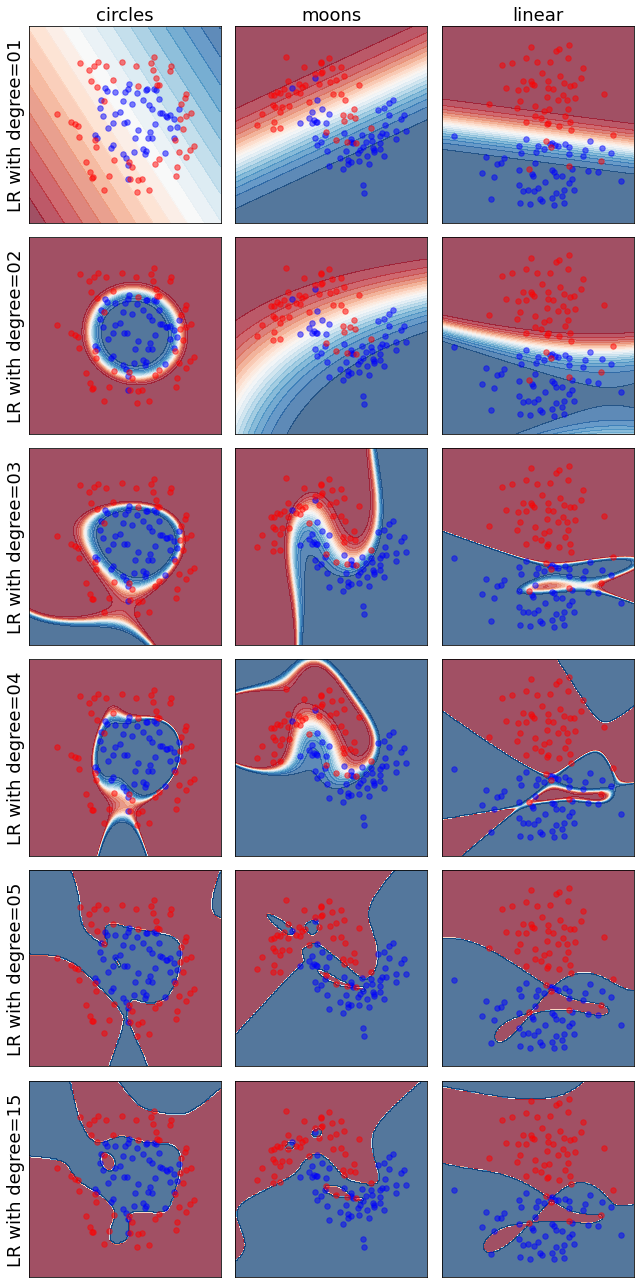

In [23]:
n_samples = 150

datasets = [
    (make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1), "circles"),
    (make_moons(n_samples=n_samples, noise=0.2, random_state=0), "moons"),
    (make_linear(n_samples=n_samples), "linear")
]

degrees = [1, 2, 3, 4, 5, 15]

n_datasets = len(datasets)
n_clfs = len(degrees) 
i = 0

plt.figure(figsize=(3 * n_datasets, 3 * n_clfs))

for n_clf, degree in enumerate(degrees):
    for n_dataset, ((X, y), dataset_name) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        clf, clf_name = get_poly_logreg(degree)
        clf.fit(X_train, y_train)
        i += 1
        ax = plt.subplot(n_clfs, n_datasets, i)
        plot_probas(clf, ax, X_train, y_train, h=h, levels=levels, colorbar=False)
        plot_data(ax, X_train, y_train, xy_labels=False, alpha=0.5)
        
        if n_clf == 0:
            plt.title(dataset_name, fontsize=18)
        
        if n_dataset % 3 == 0:
            plt.ylabel(clf_name, fontsize=18)
        
plt.tight_layout()

## Quantitative assessment of overfitting

In [24]:
dataset_names = []
clfs_names = []
train_auc_prs = []
train_auc_rocs = []
test_auc_prs = []
test_auc_rocs = []
clf_degrees = []

n_samples = 1000

datasets = [
    (make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1), "circles"),
    (make_moons(n_samples=n_samples, noise=0.2, random_state=0), "moons"),
    (make_linear(n_samples=n_samples), "linear")
]

degrees = [1, 2, 3, 4, 5, 10, 15, 20, 30]

n_datasets = len(datasets)
n_clfs = len(degrees) 
i = 0

for n_clf, degree in enumerate(degrees):
    for n_dataset, ((X, y), dataset_name) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        clf, clf_name = get_poly_logreg(degree)
        clf.fit(X_train, y_train)

        # Compute metrics
        clf_degrees.append(degree)
        clfs_names.append(clf_name)
        dataset_names.append(dataset_name)
        
        y_train_score = clf.predict_proba(X_train)[:, 1]
        y_test_score = clf.predict_proba(X_test)[:, 1]

        train_auc_roc = roc_auc_score(y_train, y_train_score)
        test_auc_roc = roc_auc_score(y_test, y_test_score)
        train_auc_pr = average_precision_score(y_train, y_train_score)
        test_auc_pr = average_precision_score(y_test, y_test_score)

        train_auc_rocs.append(train_auc_roc)
        test_auc_rocs.append(test_auc_roc)
        train_auc_prs.append(train_auc_pr)        
        test_auc_prs.append(test_auc_pr)

/home/jlechuga/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jlechuga/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [25]:
results = pd.DataFrame({
    "dataset": dataset_names,
    "degree": clf_degrees,
    "AUC-PR (train)": train_auc_prs,
    "AUC-PR (test)": test_auc_prs,
    "AUC-ROC (train)": train_auc_rocs,
    "AUC-ROC (test)": test_auc_rocs
})

In [26]:
results

,dataset,degree,AUC-PR (train),AUC-PR (test),AUC-ROC (train),AUC-ROC (test)
0,circles,1,0.447546,0.470344,0.512733,0.479070
1,moons,1,0.956388,0.936826,0.958954,0.922383
2,linear,1,0.920737,0.933142,0.912169,0.930769
3,circles,2,0.950463,0.958726,0.953584,0.961929
4,moons,2,0.956359,0.936420,0.958854,0.921675
5,linear,2,0.940788,0.928976,0.934239,0.938590
6,circles,3,0.952744,0.961248,0.954352,0.963405
7,moons,3,0.995558,0.996494,0.995915,0.995813
8,linear,3,0.940998,0.928869,0.934125,0.936346
9,circles,4,0.952598,0.958112,0.955497,0.960645


In [27]:
results_pivot = (
    results
    .pivot(index="degree", columns="dataset")
)


(
    results_pivot
    .style
    .background_gradient()
)

Text(0.5, 1.0, 'AUC-PR (train)')

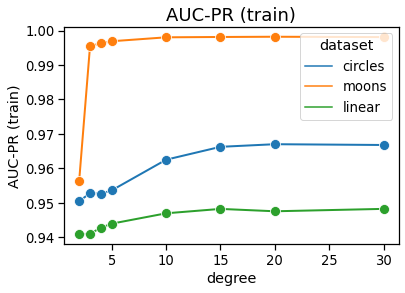

In [28]:
import seaborn as sns

sns.set_context("notebook", font_scale=1.2)

sns.lineplot(
    x="degree", 
    y="AUC-PR (train)",
    hue="dataset",
    linewidth=2,
    data=results.iloc[3:, :], 
    marker=".", 
    markersize=20
).set_title("AUC-PR (train)", fontsize=18)

Text(0.5, 1.0, 'AUC-PR (test)')

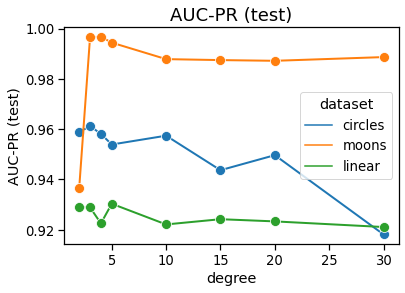

In [29]:
sns.lineplot(
    x="degree", 
    y="AUC-PR (test)",
    hue="dataset",
    linewidth=2,
    data=results.iloc[3:, :], 
    marker=".", 
    markersize=20
).set_title("AUC-PR (test)", fontsize=18)

## Polynomial logistic regression versus MLP

In [30]:
from sklearn.neural_network import MLPClassifier

n_samples = 150

datasets = [
    (make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1), "circles"),
    (make_moons(n_samples=n_samples, noise=0.2, random_state=0), "moons"),
    (make_linear(n_samples=n_samples), "linear")
]

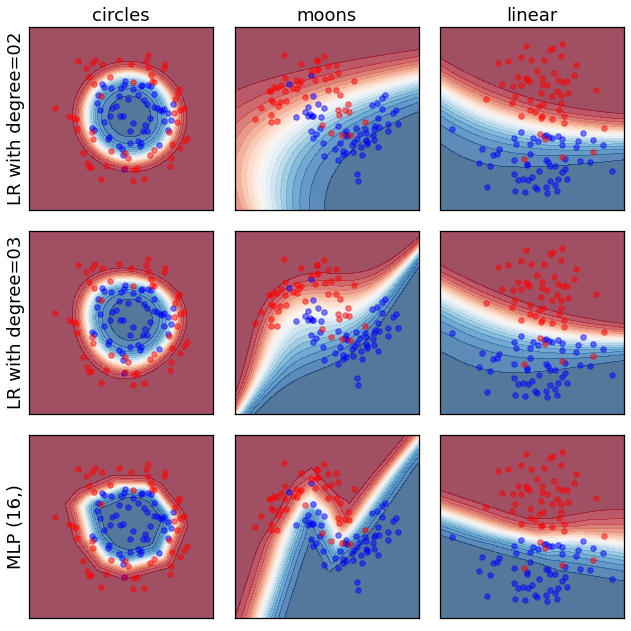

In [31]:
def get_poly_logreg(degree):
    clf = Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("scale", StandardScaler()),        
        ("logreg", LogisticRegression())
    ])
    clf_name = "LR with degree={:02d}".format(degree)
    return clf, clf_name

# Polynomial logistic regression with degree 2 and 3
poly_logreg_2 = get_poly_logreg(degree=2)
poly_logreg_3 = get_poly_logreg(degree=3)


# Multi-layer perceptron classifier with 2 hidden layers of width 16
mlp = Pipeline([
    ("scale", StandardScaler()),
    ("mlp", MLPClassifier(solver="adam", hidden_layer_sizes=(16,), batch_size=16,
                          max_iter=2000))
])

clfs = [
    poly_logreg_2,
    poly_logreg_3,
    (mlp, "MLP (16,)")
]

n_datasets = len(datasets)
n_clfs = len(clfs) 
i = 0

plt.figure(figsize=(3 * n_datasets, 3 * n_clfs))

for n_clf, (clf, clf_name) in enumerate(clfs):
    for n_dataset, ((X, y), dataset_name) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        clf.fit(X_train, y_train)

        i += 1
        # print((n_clfs, n_datasets, i), n_clf, n_dataset)
        ax = plt.subplot(n_clfs, n_datasets, i)
        plot_probas(clf, ax, X_train, y_train, h=h, levels=levels, colorbar=False)
        plot_data(ax, X_train, y_train, xy_labels=False, alpha=0.5)
        
        if n_clf == 0:
            plt.title(dataset_name, fontsize=18)
        
        if n_dataset % 3 == 0:
            plt.ylabel(clf_name, fontsize=18)
        
plt.tight_layout()

## Hyper-parameter tuning

Something is seriously wrong in what we did before: we did not performed hyper-parameter optimization using cross-validation. 
Let's do it to tune both the degree of the polynomial and regularization level of the polynomial logistic regression, and for the hyper-parameters of the MLP.
But let's do it only on the moons dataset, since it takes some time.

In [32]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

n_samples = 1000

X, y = make_moons(n_samples=n_samples, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# A stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=3)

In [33]:
poly_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2)),
    ("logreg", LogisticRegression())
])


poly_logreg_params = {
    "logreg__C": [1e-3, 1e-2, 1e-1, 1.0, 1e1, 1e2, 1e3],
    "poly__degree": [1, 2, 3, 4, 5],
}

poly_logreg_cv = GridSearchCV(poly_logreg, poly_logreg_params, n_jobs=-1, scoring="roc_auc", cv=cv)
poly_logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                       1000.0],
                         'poly__degree': [1, 2, 3, 4, 5]},
             scoring='roc_auc')

In [34]:
poly_logreg_cv.best_params_

{'logreg__C': 1000.0, 'poly__degree': 3}

In [35]:
cv = StratifiedKFold(n_splits=3)

mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(solver="adam", 
                          hidden_layer_sizes=(16,), 
                          batch_size=16,
                          max_iter=2000)
    )
])


mlp_params = {
    "mlp__batch_size": [8, 16, 32, 64, 128],
    "mlp__alpha": [1e-1, 1e-2, 1e-3, 1e-4],
    "mlp__activation": ["relu", "tanh"],
    "mlp__hidden_layer_sizes": [(16,), (32,), (16, 16,), (8, 8)]
}

mlp_cv = GridSearchCV(mlp, mlp_params, n_jobs=-1, scoring="roc_auc", cv=cv)
mlp_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('mlp',
                                        MLPClassifier(batch_size=16,
                                                      hidden_layer_sizes=(16,),
                                                      max_iter=2000))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['relu', 'tanh'],
                         'mlp__alpha': [0.1, 0.01, 0.001, 0.0001],
                         'mlp__batch_size': [8, 16, 32, 64, 128],
                         'mlp__hidden_layer_sizes': [(16,), (32,), (16, 16),
                                                     (8, 8)]},
             scoring='roc_auc')

In [36]:
mlp_cv.best_params_

{'mlp__activation': 'relu',
 'mlp__alpha': 0.0001,
 'mlp__batch_size': 32,
 'mlp__hidden_layer_sizes': (16, 16)}

In [37]:
def get_test_score(clf, X_test, y_test):
    y_test_score = clf.predict_proba(X_test)[:, 1]
    test_auc_roc = roc_auc_score(y_test, y_test_score)
    return test_auc_roc

In [38]:
get_test_score(poly_logreg_cv, X_test, y_test)

0.9958776167471819

In [39]:
get_test_score(mlp_cv, X_test, y_test)

0.995426731078905